In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
from torchvision.datasets import DatasetFolder
import torchvision
from tqdm.notebook import tqdm as tqdm

train_path = "/home/chisc/workspace/wuzhenrong/galaxy/images_gz2/"

In [2]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.')
else:
    print('CUDA is available!')
device = "cuda" if train_on_gpu else "cpu"

CUDA is available!


In [3]:
# Hyperparameters
epochs = 10
batch_size = 32
lr = 0.001

In [4]:
train_trans = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
train_data = ImageFolder(train_path, transform = train_trans)
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 2, pin_memory = True)

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 4, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 2, stride=2),
            nn.Sigmoid()
        )
    
    def forward(self, inputs):
        codes = self.encoder(inputs)
        output = self.decoder(codes)
        
        return codes, output

In [ ]:
model = AutoEncoder()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss_func = nn.BCELoss()

In [ ]:
for epoch in range(epochs):
    for x, y in tqdm(train_loader):
        x, y = x.to(device), y.to(device)
#         inputs = x.view(3, 256 * 256)
#         inputs = inputs.to(device)
        codes, outputs = model(x)
        optimizer.zero_grad()
        loss = loss_func(outputs, x)
        loss.backward()
        optimizer.step()
        
    print(f"epoch:{epoch+1}/{epochs}, Loss = {loss.item()}")
torch.save(model, "autoencoder.pkl")

In [6]:
# batch_size = 1
train_trans = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
train_data = ImageFolder(train_path, transform = train_trans)
train_loader = DataLoader(train_data, shuffle = True, num_workers = 2, pin_memory = True)

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)


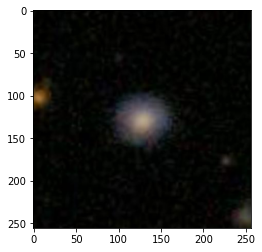

/home/chisc/.pyenv/versions/torch/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


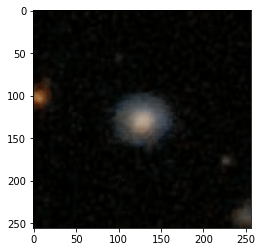

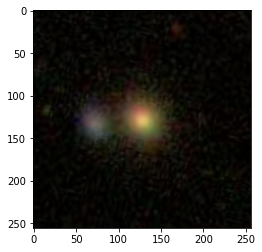

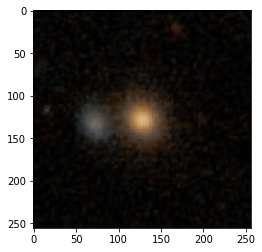

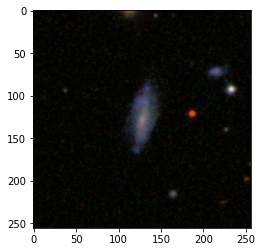

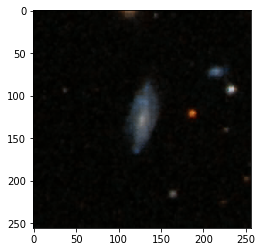

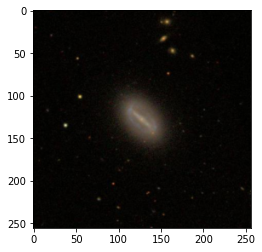

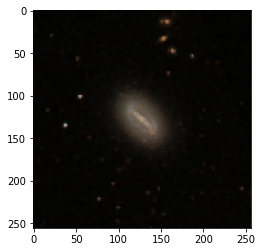

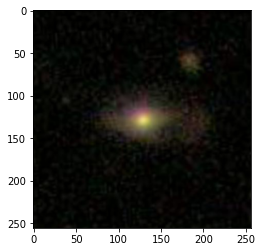

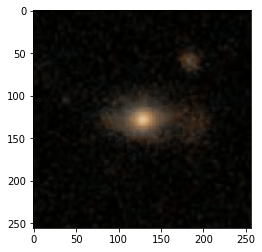

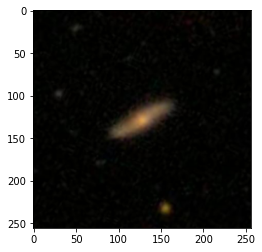

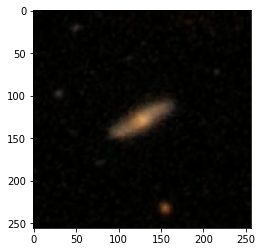

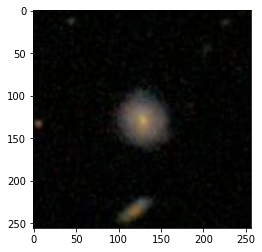

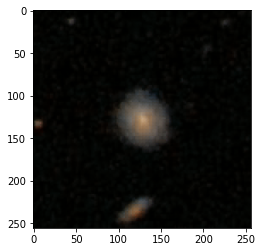

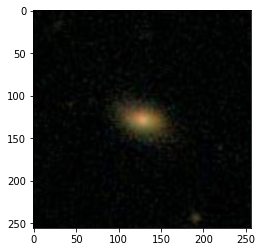

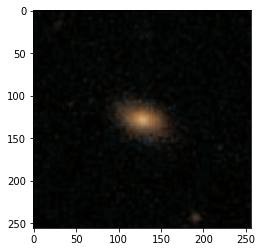

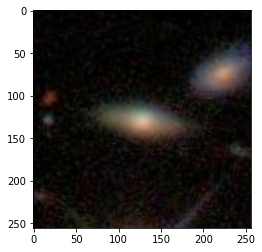

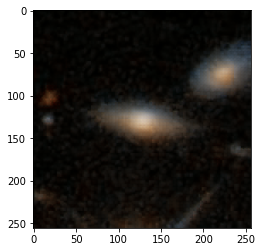

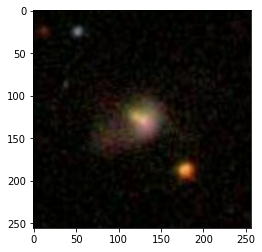

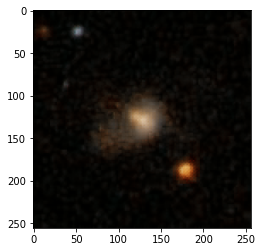

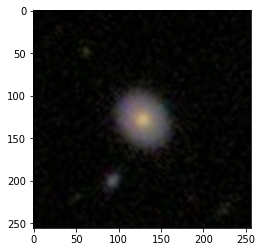

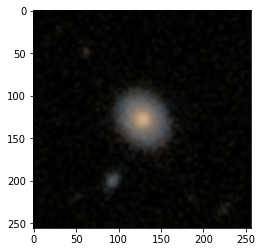

In [7]:
model = torch.load('autoencoder.pkl')
model.eval()
# model = model.to(deice)
print(model)
cnt = 0
with torch.no_grad():
    for i, j in train_loader:
        print("================================")
        i, j = i.to(device), j.to(device)
        inputs = i.squeeze()
        inputs = inputs.to('cpu')
        plt.imshow(inputs.squeeze().permute(1, 2, 0))
        plt.show()
        inputs = inputs.to(device)
        codes, output = model(i)
        
        plt.imshow(output.squeeze().to('cpu').permute(1, 2, 0))
        plt.show()
        print("================================")
        exit()
        cnt += 1
        if cnt == 11:
            break